<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/hourly_breadth_indicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplfinance --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.8 MB/s eta 0:00:00


In [2]:
import duckdb
import pandas as pd

# Paths to the databases
db_path1 = "/content/nifty50_hourly_data.duckdb"



In [3]:
# Function to get table names
def get_table_names(db_path):
    con = duckdb.connect(db_path)
    tables = con.execute("SHOW TABLES").fetchall()
    con.close()
    return [table[0] for table in tables]  # Extract table names from tuples
# Fetch table names
tables_db1 = get_table_names(db_path1)

print("Tables in nifty50_hourly_data.duckdb:", tables_db1)



Tables in nifty50_hourly_data.duckdb: ['nifty50_hourly_table']


In [4]:

# Connect to the first database and fetch data
con1 = duckdb.connect(db_path1)
df1 = con1.execute("SELECT * FROM nifty50_hourly_table").fetchdf()  # Replace with the actual table name
con1.close()




In [5]:
def calculate_percentage_above_moving_average(data,periods):
    #data = yf.download(stock_list, interval='1H' ,start=start_date)
    #data = data['Adj Close']

    # Calculate the moving average using ewm with min_periods set to 50
    ma = data.ewm(span=periods,min_periods=periods).mean()

    above_ma = data > ma
    percentage = (above_ma.sum(axis=1) / 50) * 100

    return percentage


In [6]:
!pip install logzero --q
!pip install smartapi-python==1.4.1 --q
!pip install pyotp --q

In [7]:
# package import statement
from SmartApi import SmartConnect #or from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger
import time
import os
import urllib
import json
import pandas as pd
import datetime as dt

api_key = 'xOHnB7MG'
username = 'M55123447'
pwd = '1471'
smartApi = SmartConnect(api_key)
try:
    token = "GJZACUQI2TTAIBHBA34XNFJURQ"
    totp = pyotp.TOTP(token).now()
except Exception as e:
    logger.error("Invalid Token: The provided token is not valid.")
    raise e

correlation_id = "abcde"
data = smartApi.generateSession(username, pwd, totp)

if data['status'] == False:
    logger.error(data)

else:
    # login api call
    # logger.info(f"You Credentials: {data}")
    authToken = data['data']['jwtToken']
    refreshToken = data['data']['refreshToken']
    # fetch the feedtoken
    feedToken = smartApi.getfeedToken()
    # fetch User Profile
    res = smartApi.getProfile(refreshToken)
    smartApi.generateToken(refreshToken)
    res=res['data']['exchanges']





In [8]:
#Download Nifty50 Index Data
params = {
           "exchange": "NSE",
           "symboltoken": '99926000',
           "interval": "ONE_HOUR",
           "fromdate": (dt.date.today() - dt.timedelta(350)).strftime('%Y-%m-%d %H:%M'),
           "todate": (dt.date.today()+dt.timedelta(days=1)).strftime('%Y-%m-%d %H:%M')
         }
nifty_data = smartApi.getCandleData(params)
nifty_index= pd.DataFrame(nifty_data["data"],
                               columns = ["date","open","high","low","close","volume"])
nifty_index.set_index("date",inplace=True)
nifty_index.index = pd.to_datetime(nifty_index.index)
nifty_index.index = nifty_index.index.tz_localize(None)

In [9]:
# Filtering out rows for March 1, 2025
df1 = df1[df1['date'].dt.date != pd.Timestamp("2025-03-01").date()]

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date', inplace=True)


<ipython-input-10-a469f9a4cad7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = pd.to_datetime(df1['date'])


In [11]:
df1.shape

(1747, 50)

In [12]:
percentage_above_dma = calculate_percentage_above_moving_average(df1,20)
result = calculate_percentage_above_moving_average(df1,60)

In [13]:
percentage_above_dma=percentage_above_dma.tail(213)
result=result.tail(213)
nifty_index=nifty_index.tail(213)

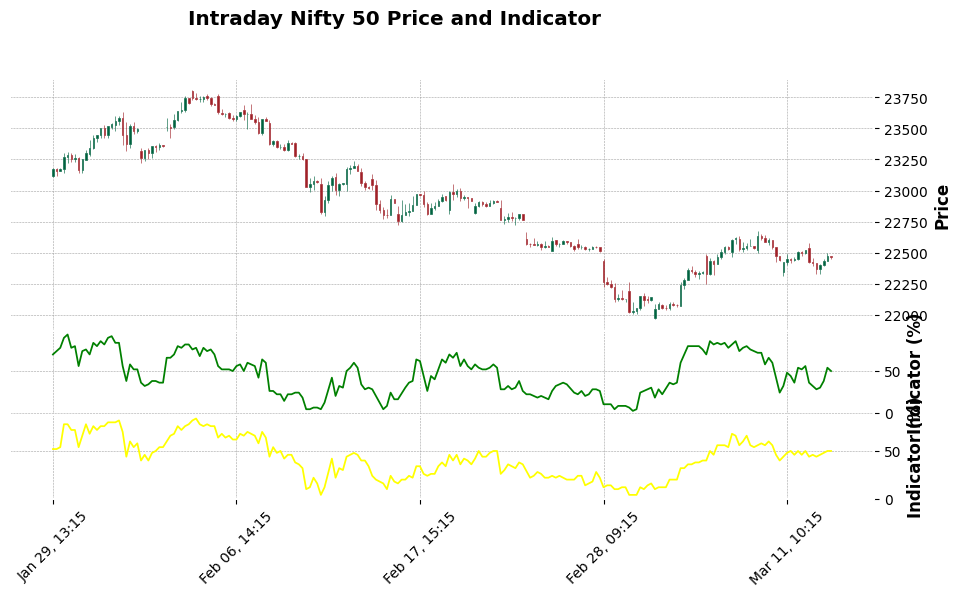

In [14]:
import mplfinance as mpf
import matplotlib.pyplot as plt

# Create an additional plot (addplot) for the indicator in a separate panel
ap_indicator = mpf.make_addplot(percentage_above_dma, panel=1, color="green", ylabel="Indicator (%)")
ap_indi_2 = mpf.make_addplot(result, panel=2, color="yellow", ylabel="Indicator (%)")

# Plot the intraday data using mplfinance:
# - Use candlestick chart for the price data
# - Add the indicator plots in separate panels
mpf.plot(
    nifty_index,
    type="candle",
    style="charles",
    title="Intraday Nifty 50 Price and Indicator",
    addplot=[ap_indicator, ap_indi_2],
    panel_ratios=(3, 1, 1),
    volume=False,
    figsize=(12, 6)
)



In [15]:
result.tail(5)

,0
date,
2025-03-12 11:15:00,44.0
2025-03-12 12:15:00,46.0
2025-03-12 13:15:00,48.0
2025-03-12 14:15:00,50.0
2025-03-12 15:15:00,50.0
